# ClarifyBot Demo

This notebook demonstrates the RL-driven adaptive question generation and reward modeling capabilities of ClarifyBot. It simulates how the system processes ambiguous human feedback, generates clarification questions using different templates, receives feedback, and adapts its strategy over time.

**Key features:**
- Explicit RL (bandit) template selection (epsilon-greedy)
- Bayesian reward modeling with uncertainty
- Logging and analytics of exploration vs. exploitation
- Visualization of template rewards, uncertainty, and selection strategy

In [1]:
# Import necessary libraries
import sys
sys.path.append('../src')
import random
import matplotlib.pyplot as plt
import pandas as pd
from llm.question_generator import QuestionGenerator, PROMPT_TEMPLATES
from rl.reward_model import RewardModel

## Step 1: Simulate Ambiguous Human Feedback

We will simulate a sequence of ambiguous feedbacks that ClarifyBot will process interactively.

In [2]:
# Simulated ambiguous feedbacks
ambiguous_feedbacks = [
    "I like the idea of a robot helping me, but I'm not sure about the speed.",
    "The robot should be friendly, but I also want it to be efficient.",
    "I want the assistant to be proactive, but not intrusive.",
    "I care about privacy, but I also want convenience."
]

## Step 2: Interactive RL Loop - Generate Questions, Simulate Feedback, and Update Rewards

For each feedback, ClarifyBot will:
- Select a question template based on current rewards (bandit policy)
- Generate clarification questions
- Simulate user feedback (random thumbs up/down)
- Update the template's reward model
- Log template selection and mode (explore/exploit)

In [5]:
# Initialize components
reward_model = RewardModel(len(PROMPT_TEMPLATES))
question_generator = QuestionGenerator(reward_model=reward_model)

# Run RL loop and simulate feedback
for round_num, feedback in enumerate(ambiguous_feedbacks, 1):
    questions, template_idx, mode = question_generator.generate_clarification_questions(feedback)
    print(f"\n--- Round {round_num} ---")
    print(f"Feedback: {feedback}")
    print(f"Template used: {template_idx+1} (mode: {mode})")
    for i, q in enumerate(questions, 1):
        print(f"Q{i}: {q}")
    # Simulate user feedback (random thumbs up/down for this template)
    user_reward = random.choice([0, 1])
    print(f"Simulated user feedback (reward): {user_reward}")
    # Update reward model
    reward_model.update(template_idx, user_reward)


--- Round 1 ---
Feedback: I like the idea of a robot helping me, but I'm not sure about the speed.
Template used: 1 (mode: exploit)
Q1: What do you mean by 'I like the idea of a robot helping me, but I'm not sure about the speed.'?
Q2: Can you clarify your preference regarding 'I like the idea of a robot helping me, but I'm not sure about the speed.'?
Q3: Could you provide more details about 'I like the idea of a robot helping me, but I'm not sure about the speed.'?
Simulated user feedback (reward): 0

--- Round 2 ---
Feedback: The robot should be friendly, but I also want it to be efficient.
Template used: 2 (mode: exploit)
Q1: What do you mean by 'The robot should be friendly, but I also want it to be efficient.'?
Q2: Can you clarify your preference regarding 'The robot should be friendly, but I also want it to be efficient.'?
Q3: Could you provide more details about 'The robot should be friendly, but I also want it to be efficient.'?
Simulated user feedback (reward): 1

--- Round 3

## Step 3: Visualize Template Rewards and Uncertainty

The frontend UI live-plots template rewards and uncertainty (error bars) using Chart.js. Here, we can also visualize the current posterior mean and standard deviation for each template.

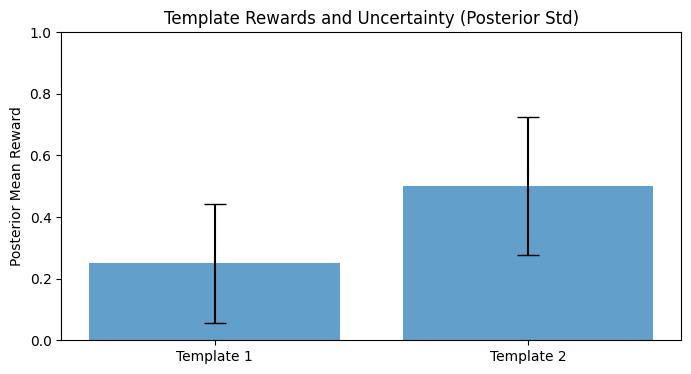

In [8]:
import numpy as np

means = [reward_model.posterior_mean(i) for i in range(len(PROMPT_TEMPLATES))]
stds = [reward_model.posterior_std(i) for i in range(len(PROMPT_TEMPLATES))]
x = np.arange(len(PROMPT_TEMPLATES))

plt.figure(figsize=(8, 4))
plt.bar(x, means, yerr=stds, capsize=8, alpha=0.7)
plt.xticks(x, [f"Template {i+1}" for i in x])
plt.ylabel("Posterior Mean Reward")
plt.title("Template Rewards and Uncertainty (Posterior Std)")
plt.ylim(0, 1)
plt.show()

## Step 4: Exploration vs. Exploitation Analytics

ClarifyBot logs every template selection and whether it was an exploration or exploitation step in `template_selection.log`. We can analyze and visualize this data to understand the RL strategy in action.

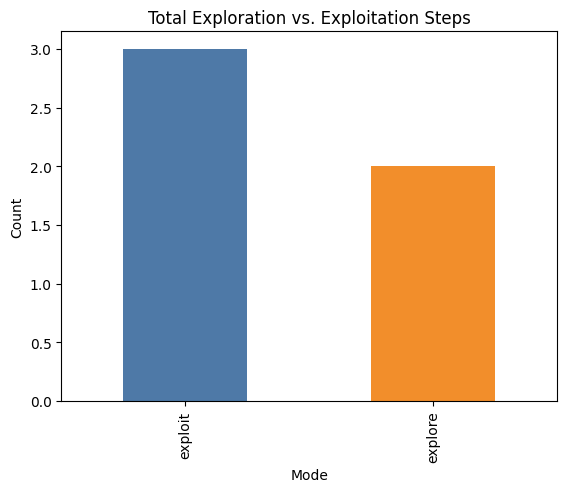

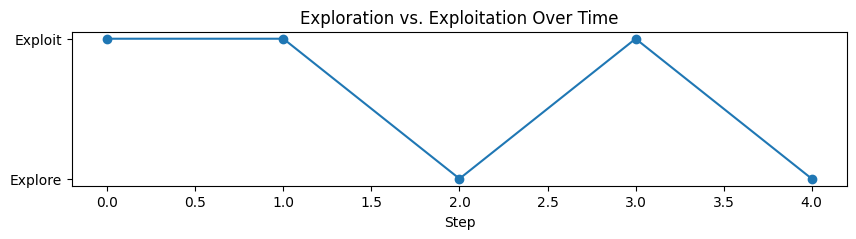

In [18]:
import os

log_path = "../template_selection.log"
if not os.path.exists(log_path):
    print("No template_selection.log found. Run the ClarifyBot app to generate log data.")
else:
    df = pd.read_csv(log_path, names=["template_idx", "mode"], delimiter="\t")
    # Drop rows where template_idx is missing or not a number
    df = df[pd.to_numeric(df["template_idx"], errors="coerce").notnull()]
    df["template_idx"] = df["template_idx"].astype(int)
    df["mode"] = df["mode"].astype(str)

    # Bar chart: total explore vs. exploit
    mode_counts = df["mode"].value_counts()
    if not mode_counts.empty:
        mode_counts.plot(kind="bar", color=["#4e79a7", "#f28e2b"])
        plt.title("Total Exploration vs. Exploitation Steps")
        plt.ylabel("Count")
        plt.xlabel("Mode")
        plt.show()
    else:
        print("No valid exploration/exploitation data to plot.")

    # Time series: mode over time
    if not df.empty:
        plt.figure(figsize=(10, 2))
        plt.plot(df["mode"].map({"explore": 0, "exploit": 1}), marker="o", linestyle="-")
        plt.yticks([0, 1], ["Explore", "Exploit"])
        plt.xlabel("Step")
        plt.title("Exploration vs. Exploitation Over Time")
        plt.show()
    else:
        print("No valid exploration/exploitation data for time series plot.")

## Step 5: Reward Modeling and Confidence

You can use the RewardModel to infer the overall reward from a list of user feedback and summarize preferences.

In [19]:
# Example: Aggregate feedback and infer reward
feedback_list = [random.choice([0, 1]) for _ in range(10)]
print("Simulated feedback list:", feedback_list)
reward = reward_model.infer_reward(feedback_list)
print("Inferred average reward:", reward)

Simulated feedback list: [0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Inferred average reward: 0.3


## Conclusion

This demo shows how ClarifyBot adaptively selects question-generation strategies using RL, updates template rewards based on feedback, and visualizes the learning process. The new analytics and logging approach enables research-quality tracking of exploration vs. exploitation and reward uncertainty.